# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [28]:
import pickle
import matplotlib.colors
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
    
training_file = "train.p"
testing_file = "test.p"

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

with open("train.p", mode='rb') as f:
    train = pickle.load(f)
with open("test.p", mode='rb') as f:
    test = pickle.load(f)
    
X_tr, y_tr = (train['features'], train['labels'])
X_test0, y_test = (test['features'], test['labels'])

print(X_tr[0].shape)

(32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [29]:
n_tr = len(X_tr)
n_test = len(y_test)

image_shape = X_tr[0].shape

n_classes = len(set(y_tr))

print("Number of training examples =", n_tr)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [30]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
import csv

labels = {}
with open('signnames.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        labels[int(row['ClassId'])] = row['SignName']   
        
print("Loaded %s labels" % len(labels))
i = random.randint(0, len(labels))
print("For example %s - %s" % (i, labels[i]))

Loaded 43 labels
For example 35 - Ahead only


In [32]:
def show_image(x, title):
    image = x.squeeze()
    plt.figure(figsize=(1,1))
    #plt.imshow(matplotlib.colors.hsv_to_rgb(image))
    plt.imshow(image)
    #plt.imshow(image, cmap='gray')
    plt.title(title, loc='left')    
    
def show_sign(Xs, ys, i):
    show_image(Xs[i], labels[ys[i]])
    
def show_label_stats(y):
    (sta, counts) = np.unique(y, return_counts=True)
    for i in range(len(sta)):
        print("%s - %s (%s)" % (counts[i], labels[sta[i]], sta[i]))
        
show_label_stats(y_tr)

210 - Speed limit (20km/h) (0)
2220 - Speed limit (30km/h) (1)
2250 - Speed limit (50km/h) (2)
1410 - Speed limit (60km/h) (3)
1980 - Speed limit (70km/h) (4)
1860 - Speed limit (80km/h) (5)
420 - End of speed limit (80km/h) (6)
1440 - Speed limit (100km/h) (7)
1410 - Speed limit (120km/h) (8)
1470 - No passing (9)
2010 - No passing for vehicles over 3.5 metric tons (10)
1320 - Right-of-way at the next intersection (11)
2100 - Priority road (12)
2160 - Yield (13)
780 - Stop (14)
630 - No vehicles (15)
420 - Vehicles over 3.5 metric tons prohibited (16)
1110 - No entry (17)
1200 - General caution (18)
210 - Dangerous curve to the left (19)
360 - Dangerous curve to the right (20)
330 - Double curve (21)
390 - Bumpy road (22)
510 - Slippery road (23)
270 - Road narrows on the right (24)
1500 - Road work (25)
600 - Traffic signals (26)
240 - Pedestrians (27)
540 - Children crossing (28)
270 - Bicycles crossing (29)
450 - Beware of ice/snow (30)
780 - Wild animals crossing (31)
240 - End of

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [33]:
### for some reason scaling 0..1 doesn't play well with rotation used below so scaling is done below, after rotation

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
Scaling 0..1 seems quite important as it makes learning much faster.
I've also tried converting images to HSV but didn't get as good results as I hoped so I keep everything in RGB.

210 - Speed limit (20km/h) (0)
2500 - Speed limit (30km/h) (1)
2250 - Speed limit (50km/h) (2)
1410 - Speed limit (60km/h) (3)
1980 - Speed limit (70km/h) (4)
1860 - Speed limit (80km/h) (5)
420 - End of speed limit (80km/h) (6)
1440 - Speed limit (100km/h) (7)
1410 - Speed limit (120km/h) (8)
1470 - No passing (9)
2010 - No passing for vehicles over 3.5 metric tons (10)
1320 - Right-of-way at the next intersection (11)
2100 - Priority road (12)
2160 - Yield (13)
780 - Stop (14)
630 - No vehicles (15)
420 - Vehicles over 3.5 metric tons prohibited (16)
1110 - No entry (17)
1200 - General caution (18)
210 - Dangerous curve to the left (19)
360 - Dangerous curve to the right (20)
2500 - Double curve (21)
390 - Bumpy road (22)
510 - Slippery road (23)
270 - Road narrows on the right (24)
1500 - Road work (25)
600 - Traffic signals (26)
2500 - Pedestrians (27)
540 - Children crossing (28)
270 - Bicycles crossing (29)
450 - Beware of ice/snow (30)
780 - Wild animals crossing (31)
240 - End 

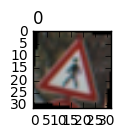

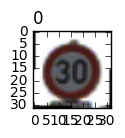

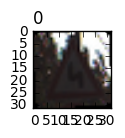

In [34]:
from scipy.ndimage.interpolation import rotate, shift
import numpy
from random import random as rnd

X_tr_ex = X_tr
y_tr_ex = y_tr

def add_more(klass, target_count):
    global X_tr_ex
    global y_tr_ex
    ss = X_tr[y_tr == klass]
    ii = numpy.random.randint(len(ss),size=target_count-len(ss))
    samples = [rotate(i,angle=rnd()*20-10, reshape=False) for i in ss[ii, :]]
    show_image(samples[0], "0")
    
    X_tr_ex = np.append(X_tr_ex, samples, axis=0)
    y_tr_ex = np.append(y_tr_ex, [klass for i in range(len(samples))], axis=0)

# pedestrians - 27 - get confused with some other signs so let's make more of them
add_more(27, 2500)
add_more(1, 2500)
#add_more(18, 2500)
add_more(21, 2500)
#add_more(25, 2500)

show_label_stats(y_tr_ex)

X_train, X_validation, y_train, y_validation = train_test_split(X_tr_ex, y_tr_ex, test_size=0.2)

def preprocess(images):
    return np.asarray([i/255.0 for i in images])

X_train = preprocess(X_train)
X_validation = preprocess(X_validation)
X_test = preprocess(X_test0)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
I've split original training data into 80% training and 20% validation. Test data is not shown to the network until very last moment to avoid overfitting.

In [35]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Below is LeNet with increased sizes of layers and added dropouts
def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x15.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 15), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(15))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x15. Output = 14x14x15.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x40.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 15, 40), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(40))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x40. Output = 5x5x40.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x40. Output = 1000.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1000. Output = 500.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1000, 500), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(500))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # dropout to prevent overfitting
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 500. Output = 300.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(500, 300), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(300))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # One more dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 300. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(300, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [36]:

def fully_connected(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    fc0   = flatten(x)
    
    # Layer 3: Fully Connected. Input = 1000. Output = 500.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(3072, 800), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(800))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # dropout to prevent overfitting
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 500. Output = 300.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(800, 200), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(200))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # One more dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 300. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(200, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [37]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
Architecture is based on LeNet from the lab with increased layer sizes and added dropouts to decrease overfitting.
LeNet works well with MNIST data and since in this project traffic signs are already located, extracted and resized to 32x32, inpu type is similar to MNIST so LeNet should be a good starting point. Signs in the images are not centered and might move within the image so convolution layers should help to decrease number of parameters and make it possible to locate signs even if they are shifted within the image.
Paddings are everywhere 'VALID' to ensure learning is done on as realistic images as possible.

The network has the following layers:
- input - 32x32x3
- convolution - with kernel 5x5x3 and with 'valid' padding resulting in 28x28x15
hoping to "learn" some 5x5-sized features such as lines, curves and corners
- activation (relu)
- pooling - max with kernel size 2x2x1, shrinking data to 14x14x15
strides match kernel size to make sure each pixel is taken into account once and only once
- convolution - kernel 5x5x15, result 10x10x40
- activation (relu)
- pooling to 5x5x40
- flatten to 1000 nodes
- fully connected from 1000 to 500
- activation (relu)
- dropout to avoid overfitting with keep_probability of .5
- fully connected from 500 to 300
- activation (relu)
- dropout with keep_probability of 0.5. In evaluation run this parameter is set 1.0 to ensure maximum information is harnesses from the network
- fully connected (output) from 300 to 43


In [38]:
rate = 0.001
BATCH_SIZE = 200

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [39]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, keep_probability):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_probability})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [40]:
import os.path
import itertools

with tf.Session() as sess:
    # saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess.run(tf.initialize_all_variables())
    
    print("Training...")
    print()
    acc = []
    for i in itertools.count():
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, len(X_train), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation, 1.0)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        acc.append(validation_accuracy)
        
        if len(acc) >= 2:
            recent_improvement = acc[-1] - acc[-2]
            print("Recent improvement is %s" % recent_improvement)
            if recent_improvement < 0.01:
                if rate > 0.0003:
                    acc = []
                    rate = rate / 2
                    BATCH_SIZE = int(BATCH_SIZE * 1.3)
                    print("Rate is now %s and BATCH_SIZE is %s" % (rate, BATCH_SIZE))
                else:
                    print("Not improving anymore")
                    break
            
        previous_validation_accuracy = validation_accuracy
        
        print()
        
    saver.save(sess, os.path.abspath('lenet'))
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.807

EPOCH 2 ...
Validation Accuracy = 0.941
Recent improvement is 0.134221323309

EPOCH 3 ...
Validation Accuracy = 0.969
Recent improvement is 0.0280054468383

EPOCH 4 ...
Validation Accuracy = 0.982
Recent improvement is 0.0124089161989

EPOCH 5 ...
Validation Accuracy = 0.986
Recent improvement is 0.00455373189054
Rate is now 0.0005 and BATCH_SIZE is 260

EPOCH 6 ...
Validation Accuracy = 0.989

EPOCH 7 ...
Validation Accuracy = 0.990
Recent improvement is 0.00102458839968
Rate is now 0.00025 and BATCH_SIZE is 338

EPOCH 8 ...
Validation Accuracy = 0.993

EPOCH 9 ...
Validation Accuracy = 0.992
Recent improvement is -0.000910750693745
Not improving anymore
Model saved


In [41]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test, 1.0)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.949


In [42]:
def matches(class_x):
    sess = tf.get_default_session()
    labs = tf.argmax(logits, 1)
    res = sess.run(labs, feed_dict={x:class_x, keep_prob:1.0})
    print(np.unique(res,return_counts=True))
    

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    matches(X_test[y_test == 24])
    matches(X_test[y_test == 27])
    matches(X_test[y_test == 30])
    
    accuracies = []
    for c in range(n_classes):
        class_accuracy = evaluate(X_test[y_test == c], y_test[y_test == c], 1.0)
        accuracies.append({"class":c, 'accuracy':class_accuracy})
        
accuracies.sort(key=lambda p: p['accuracy'])

print(accuracies)
#        print("Class {} Accuracy = {:.3f}".format(c, class_accuracy))
    


(array([11, 18, 21, 23, 24, 25, 27, 29, 30, 31]), array([ 1,  1,  3,  2, 71,  1,  8,  1,  1,  1]))
(array([ 1, 21, 22, 27]), array([24,  1,  5, 30]))
(array([ 8, 11, 20, 21, 23, 24, 25, 26, 29, 30, 31, 38]), array([  1,   3,   7,   8,   3,   3,   1,   2,   4, 105,  10,   3]))
[{'accuracy': 0.5, 'class': 27}, {'accuracy': 0.69999998807907104, 'class': 30}, {'accuracy': 0.78888893127441406, 'class': 24}, {'accuracy': 0.848718007405599, 'class': 18}, {'accuracy': 0.86000001430511475, 'class': 6}, {'accuracy': 0.86111116409301758, 'class': 26}, {'accuracy': 0.86666667461395264, 'class': 28}, {'accuracy': 0.86666667461395264, 'class': 41}, {'accuracy': 0.8777778148651123, 'class': 21}, {'accuracy': 0.89555558946397573, 'class': 7}, {'accuracy': 0.90000003576278687, 'class': 0}, {'accuracy': 0.90317455416633974, 'class': 5}, {'accuracy': 0.91666674613952637, 'class': 36}, {'accuracy': 0.935555550787184, 'class': 8}, {'accuracy': 0.93777782758076988, 'class': 3}, {'accuracy': 0.93958331321676

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Batch size affects training performance! Batch size 10 is slow and accuracy is very unstable, it goes up and down between epochs between 90-95%. I've ended up with adaptive batch size and learning rate. When training reaches validation accuracy plateau, learning rate gets halved and batch size gets increased to try and find a better optimization. 30-40 epochs are usually enough to reach maximum validation accuracy.

I got the following accuracy during experiments:
No image preprocessing:
- validation accuracy rarely goes above 94-96%.
- test accuracy is ~85-87%.

Converted to grayscale:
- validation 98%
- test 90%
This looks weird because color carries information about the sign. I decided to go back to color.

Increased sizes of layers in LeNet:
- validation ~98%
- test ~89%

Even larger layers:
- validation ~99%
- test ~89%
Looks like the problem is in overfitting.

Added dropout:
- validation ~99%
- test 93%

Based on statistics, pedestrians sign gets detected incorrectly in ~50%. After adding more samples of conflicting signs:
- validation 99%
- test 95%

"Pedestrians" sign is very uncertain. I've tried adding more train data by rotating original images but it doesn't seem to help much. Original data set needs improvements.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
LeNet can solve similar problems so I chose it and made small modifications such as increased layer sizes and added dropout. Then tuning parameters was trial and error when I was changing certain parameter or algorithm, running and and seeing how it affected the result accuracy.
I've tried a fully connected network and got test accuracy of about 82% which means that input data set is not comprehensive enough and it doesn't have to be because these are images and convolutional layers work well on them given that the sign can be anywhere on the image. Traffic light at the top left corner and bottom right mean the same thing so convolution is the best approach here.
I chose 2 convolutional layers and 3 fully conneced based on LeNet from the lab. Convolutional filters should be able to find patterns such as corners, lines, etc. and subsequent fully connected layers "connect the dots".

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

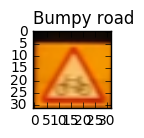

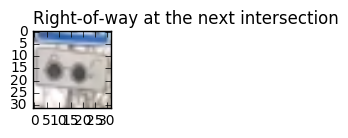

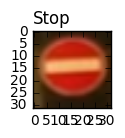

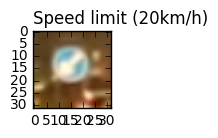

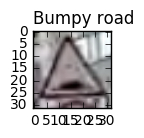

In [43]:
from scipy import misc
import glob

#files = glob.glob("*.png")
files = ['sign10.png','sign12.png','sign6.png','sign5.png','sign3.png']
images = np.asarray([preprocess(misc.imread(image_path)) for image_path in files])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    label = tf.nn.softmax(logits)
    results = sess.run(label, feed_dict={x:images,keep_prob:1})
    for i in range(len(results)):
        calculated = labels[np.argmax(results[i])]
        show_image(images[i], calculated)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
Signs that have not seen before still get classified into one of the categories. I guess there could be some threshold and when maximum logit is below is then classified could return "don't know"

In [44]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

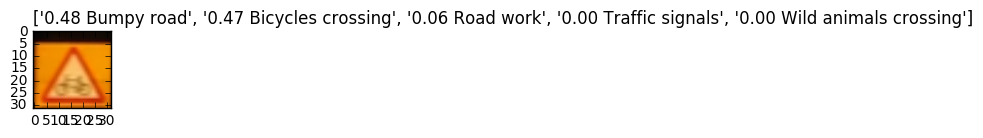

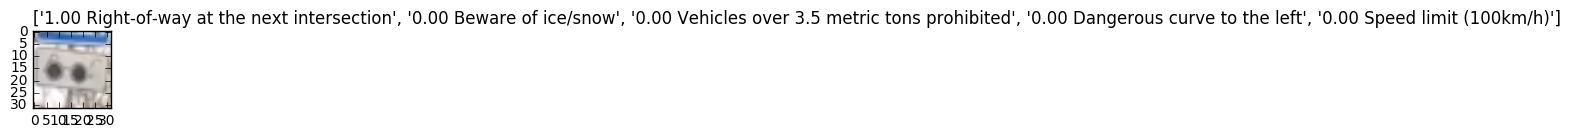

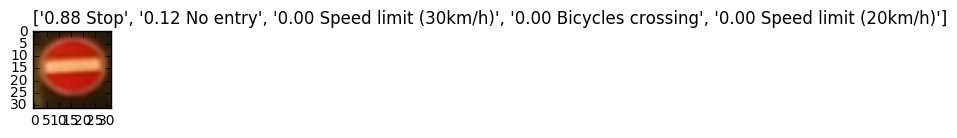

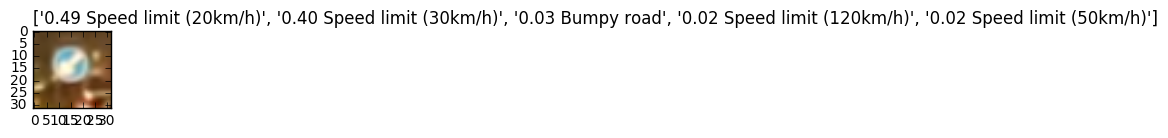

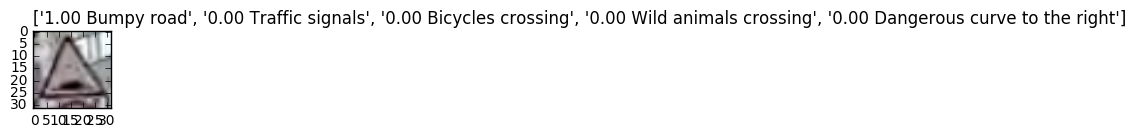

In [45]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    k = 5
    tops = tf.nn.top_k(tf.nn.softmax(logits), k=k)
    r = sess.run(tops, feed_dict={x:images,keep_prob:1})
    for i in range(len(images)):        
        show_image(images[i], ["%.2f %s" % (r.values[i][j], labels[r.indices[i][j]]) for j in range(k)])


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
Model is certain in signs that it has been trained on. For sign "blind pedestrians" the model is rather certain that it's a "right of way at the next intersection" which is worrying. The other unknown sign has also been classified with high certainty. This means that it's best to have full set of all known signs rather than deciding whether a sign is "unknown" based on low softmax.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.